# Understanding TARDIS: Line Interactions, Estimators, and Plasma Choices

> **Note:** We strongly recommend turning off code autocompletion for this notebook. This exercise is designed to engage your understanding of TARDIS Monte Carlo physics, spectrum generation, and plasma treatments, rather than relying on automated suggestions. In VSCode, you can temporarily disable autocomplete in notebook cells by navigating to **Settings → Notebook: Suggest Enabled** and unchecking the box, or by creating a workspace with a `.vscode/settings.json` file containing `"notebook.suggest.enabled": false`. This will help you focus on understanding the physics behind each step.

In [1]:
from matplotlib import pyplot as plt
from tardis import run_tardis
from tardis.io.configuration.config_reader import Configuration
import numpy as np
from astropy import units as u, constants as const
from pathlib import Path
import pandas as pd

Iterations:          0/? [00:00<?, ?it/s]

Packets:             0/? [00:00<?, ?it/s]

In [2]:
from tardis.io.atom_data import download_atom_data
# Download the Kurucz CD23 atomic data for H and He. This is a basic atomic data set. Will not download if already present.
download_atom_data('kurucz_cd23_chianti_H_He_latest')

Atomic Data kurucz_cd23_chianti_H_He_latest already exists in /Users/joshuashields/Downloads/tardis-data/kurucz_cd23_chianti_H_He_latest.h5. Will not download - override with force_download=True.


In [5]:
conf = Configuration.from_yaml('tardis_example.yml') 
conf.montecarlo.no_of_packets=1e4 
conf.montecarlo.iterations = 10  
conf.montecarlo.last_no_of_packets = 1e5
conf.montecarlo.convergence_strategy.stop_if_converged = True
conf.montecarlo.convergence_strategy.hold_iterations = 4

## Setting Up for Deep Analysis

We'll start with a well-converged TARDIS simulation using the parameters you learned to optimize in the morning session. This allows us to focus on understanding the detailed physics rather than convergence issues.

<div style="background-color: #e3f2fd; border-left: 4px solid #2196f3; padding: 10px; margin: 10px 0;">
<strong>**Key Focus:**</strong> Today we're shifting from "making TARDIS work" to "understanding how TARDIS works" - the Monte Carlo physics, spectrum generation, and advanced plasma treatments.
</div>

In [4]:
sim = run_tardis(conf, virtual_packet_logging=True)

BokehModel(combine_events=True, render_bundle={'docs_json': {'33fece26-0d3f-4603-9a92-edd5e906e9cf': {'version…

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


TqdmHBox(children=(HTML(value='Iterations:', layout=Layout(width='6%')), FloatProgress(value=0.0, layout=Layou…

TqdmHBox(children=(HTML(value='Packets:\u2007\u2007\u2007', layout=Layout(width='6%')), FloatProgress(value=0.…

# Line Interaction, the Macro Atom, and Fluorescence

### Understanding the Macro Atom: Beyond Simple Scattering

The macro atom is TARDIS's sophisticated treatment of how packets interact with atomic lines. Rather than simple scattering, it models the complex pathways an atom can take when excited by a photon.

**$\blacktriangleright$ Why Macro Atoms Matter:**

When a photon excites an atom, the atom doesn't have to re-emit at the same frequency. The macro atom treatment allows:
1. **Fluorescence:** Absorption at one frequency, emission at another
2. **Collisional de-excitation:** Energy can be converted to kinetic energy instead of radiation
3. **Cascade processes:** Multi-step pathways through different energy levels

Let's explore the macro atom data structure and see how different interaction types create different spectral signatures.

In [8]:
sim.plasma.macro_atom_data

,atomic_number,ion_number,source_level_number,destination_level_number,transition_type,transition_probability,transition_line_id,lines_idx,destination_level_idx,source_level_idx
33936,8,0,0,31,1,0.000000e+00,21996,3225,31,0
33937,8,0,0,6,1,0.000000e+00,22020,3965,6,0
33938,8,0,0,149,1,0.000000e+00,21928,3077,149,0
33939,8,0,0,139,1,0.000000e+00,21934,3083,139,0
33940,8,0,0,129,1,0.000000e+00,21944,3089,129,0
...,...,...,...,...,...,...,...,...,...,...
194272,20,8,70,52,0,5.590259e+09,108995,1712,4404,4422
194273,20,8,70,62,-1,6.244666e+08,109108,3148,4414,4422
194274,20,8,70,62,0,7.501002e+09,109108,3148,4414,4422
194275,20,8,70,63,-1,7.236178e+09,109109,3149,4415,4422


### Exploring Macro Atom Transition Data

**$\blacktriangleright$ Understanding the Data Structure:**

The macro atom data contains the physics of how excited atoms can de-excite:

1. **Transition types:** Numbers indicating whether the transition goes up, down without emission, or down with emission
2. **Transition probabilities:** Weights that determine which pathway the macro atom follows
3. **Source and destination levels:** The atomic states involved in each possible transition

This data encodes the quantum mechanical pathways available to excited atoms, allowing TARDIS to model complex fluorescence and collision processes beyond simple scattering.

Let's now explore how different line interaction treatments affect the resulting spectra by progressively adding complexity to the atomic physics.

In [9]:
conf.plasma.line_interaction_type = 'scatter'
sim = run_tardis(conf, virtual_packet_logging=True)

BokehModel(combine_events=True, render_bundle={'docs_json': {'22f0ef17-491b-40bc-95c4-42378e14b7b4': {'version…

TqdmHBox(children=(HTML(value='Iterations:', layout=Layout(width='6%')), FloatProgress(value=0.0, layout=Layou…

TqdmHBox(children=(HTML(value='Packets:\u2007\u2007\u2007', layout=Layout(width='6%')), FloatProgress(value=0.…

We provide a block of code below that grabs the frequencies of packets before and after they interact. You can investigate it if you want, but feel free to just examine the output plot as well since we go through a couple parts of TARDIS that we haven't had time to cover. 

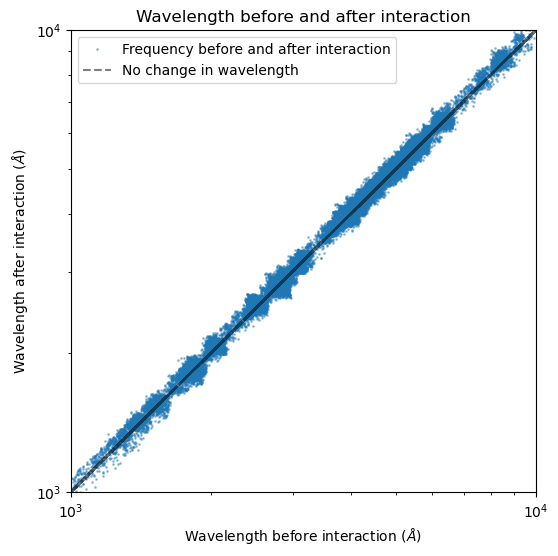

In [10]:
# Get the mask for the packets that experience line interaction as the interaction
line_interaction_mask = sim.transport.transport_state.last_interaction_type == 2

# get the frequency of the packets before the interaction
freq_before_interaction = (
    sim.transport.transport_state.last_interaction_in_nu[line_interaction_mask] * u.Hz
)

# get the frequency of the packets after the interaction
freq_after_interaction = sim.transport.transport_state.output_nu[
    line_interaction_mask
]

# convert the frequencies to wavelength
wavelength_before_interaction = (const.c / freq_before_interaction).to(u.AA)
wavelength_after_interaction = (const.c / freq_after_interaction).to(u.AA)

# plot the frequencies before and after the interaction and color code by the ion type
plt.figure(figsize=(6, 6))
plt.plot(
    wavelength_before_interaction,
    wavelength_after_interaction,
    "o",
    markersize=1,
    alpha=0.4,
    label='Frequency before and after interaction'
)
plt.plot(
    wavelength_before_interaction,
    wavelength_before_interaction,
    "k--",
    alpha=0.5,
    label='No change in wavelength'
)
plt.xlabel(r"Wavelength before interaction ($\AA$)")
plt.ylabel(r"Wavelength after interaction ($\AA$)")
plt.title("Wavelength before and after interaction")
plt.xscale("log")
plt.yscale("log")
plt.xlim(1e3, 1e4)
plt.ylim(1e3, 1e4)
plt.legend()

### **ANALYZE**: Simple Scattering Patterns

**$\blacktriangleright$ TASK -  Interpretation Challenge** - Study the wavelength interaction plot for scatter mode:

Even in the simplest case (scatter), you see interesting structure rather than a perfect one-to-one line. 

1. **Blocky structure:** Why do you see distinct rectangular regions rather than smooth distributions?

2. **Departure from diagonal:** What physical effects cause packets to change wavelength even in "scatter" mode?

**Hint:** Think about the Doppler effect and the velocity structure you explored in the morning sessions. What happens when packets interact with moving material?

## Double click to edit this cell and put your thoughts down here. 

## solution
1. You see a blocky structure that comes from wavelengths accessible or inaccessible to a certain line. At some point you need to redshift so much that the packet will escape the ejecta before it would hit a certain line, which causes the hard cutoff. 

2. The packets change frequency because the packets are doppler shifted into the comoving ejecta, and then when they are transformed back into lab frame, there's a new direction dependent doppler shift. This happens even when the packets are scattered. 

Now let's switch on the more sophisticated line interaction treatments and see what happens to our interaction plots.

In [11]:
conf.plasma.line_interaction_type = 'downbranch'
sim = run_tardis(conf, virtual_packet_logging=True)

BokehModel(combine_events=True, render_bundle={'docs_json': {'5a62eee8-5f1b-44ba-9130-b49e1d1c85e5': {'version…

TqdmHBox(children=(HTML(value='Packets:\u2007\u2007\u2007', layout=Layout(width='6%')), FloatProgress(value=0.…

TqdmHBox(children=(HTML(value='Iterations:', layout=Layout(width='6%')), FloatProgress(value=0.0, layout=Layou…

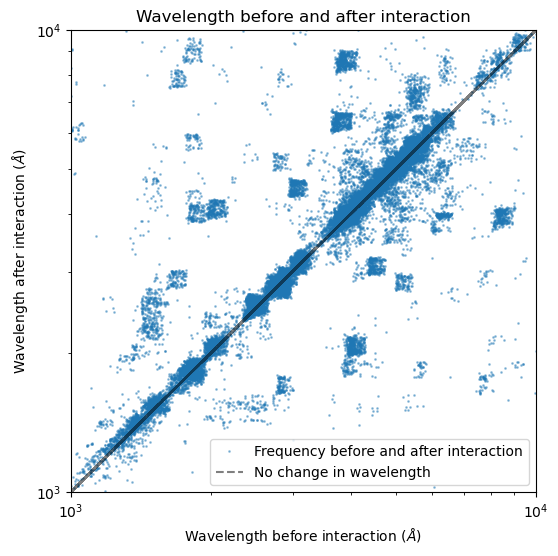

In [12]:
# Get the mask for the packets that experience line interaction as the interaction
line_interaction_mask = sim.transport.transport_state.last_interaction_type == 2

# get the frequency of the packets before the interaction
freq_before_interaction = (
    sim.transport.transport_state.last_interaction_in_nu[line_interaction_mask] * u.Hz
)

# get the frequency of the packets after the interaction
freq_after_interaction = sim.transport.transport_state.output_nu[
    line_interaction_mask
]

# convert the frequencies to wavelength
wavelength_before_interaction = (const.c / freq_before_interaction).to(u.AA)
wavelength_after_interaction = (const.c / freq_after_interaction).to(u.AA)

# plot the frequencies before and after the interaction and color code by the ion type
plt.figure(figsize=(6, 6))
plt.plot(
    wavelength_before_interaction,
    wavelength_after_interaction,
    "o",
    markersize=1,
    alpha=0.4,
    label='Frequency before and after interaction'
)
plt.plot(
    wavelength_before_interaction,
    wavelength_before_interaction,
    "k--",
    alpha=0.5,
    label='No change in wavelength'
)
plt.xlabel(r"Wavelength before interaction ($\AA$)")
plt.ylabel(r"Wavelength after interaction ($\AA$)")
plt.title("Wavelength before and after interaction")
plt.xscale("log")
plt.yscale("log")
plt.xlim(1e3, 1e4)
plt.ylim(1e3, 1e4)
plt.legend()

### Downbranch: Introducing Fluorescence

**$\blacktriangleright$ Enhanced Physics** - The downbranch mode allows atoms to de-excite to lower energy states than they were excited from, enabling fluorescence. Note that this doesn't mean the packets will be at lower frequencies though, because the packet might excite to a transition like 4 -> 5, and then 5 -> 1, which is a more energetic transition. 

**Observe the changes:** Notice how the interaction patterns now include patches away from the one-to-one line where packets depart significantly from their initial wavelengths.

**Physical meaning:** This represents fluorescence processes where a high-energy photon excites an atom, which then emits at a different (typically longer) wavelength. This is a crucial process in supernova spectra.

In [13]:
conf.plasma.line_interaction_type = 'macroatom'
sim = run_tardis(conf, virtual_packet_logging=True)

BokehModel(combine_events=True, render_bundle={'docs_json': {'e4ac88dd-c2c9-4cbb-8151-897508a51feb': {'version…

TqdmHBox(children=(HTML(value='Packets:\u2007\u2007\u2007', layout=Layout(width='6%')), FloatProgress(value=0.…

TqdmHBox(children=(HTML(value='Iterations:', layout=Layout(width='6%')), FloatProgress(value=0.0, layout=Layou…

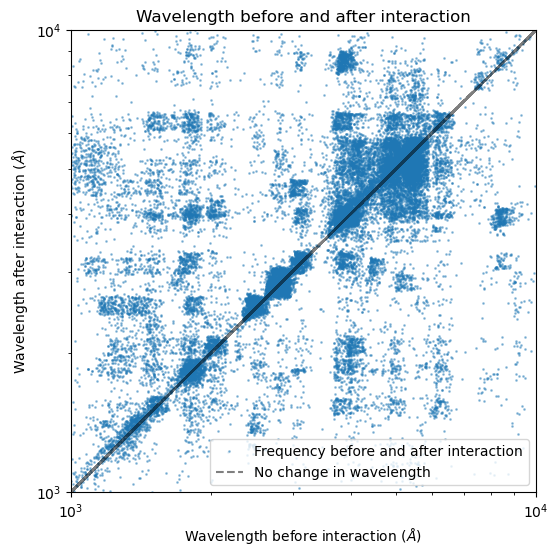

In [14]:
# Get the mask for the packets that experience line interaction as the interaction
line_interaction_mask = sim.transport.transport_state.last_interaction_type == 2

# get the frequency of the packets before the interaction
freq_before_interaction = (
    sim.transport.transport_state.last_interaction_in_nu[line_interaction_mask] * u.Hz
)

# get the frequency of the packets after the interaction
freq_after_interaction = sim.transport.transport_state.output_nu[
    line_interaction_mask
]

# convert the frequencies to wavelength
wavelength_before_interaction = (const.c / freq_before_interaction).to(u.AA)
wavelength_after_interaction = (const.c / freq_after_interaction).to(u.AA)

# plot the frequencies before and after the interaction and color code by the ion type
plt.figure(figsize=(6, 6))
plt.plot(
    wavelength_before_interaction,
    wavelength_after_interaction,
    "o",
    markersize=1,
    alpha=0.4,
    label='Frequency before and after interaction'
)
plt.plot(
    wavelength_before_interaction,
    wavelength_before_interaction,
    "k--",
    alpha=0.5,
    label='No change in wavelength'
)
plt.xlabel(r"Wavelength before interaction ($\AA$)")
plt.ylabel(r"Wavelength after interaction ($\AA$)")
plt.title("Wavelength before and after interaction")
plt.xscale("log")
plt.yscale("log")
plt.xlim(1e3, 1e4)
plt.ylim(1e3, 1e4)
plt.legend()

### Full Macro Atom: Complete Atomic Physics

**$\blacktriangleright$ Most Sophisticated Treatment** - The full macro atom allows transitions from any atomic state to any other accessible state.

**Key observations:**
1. **Scattering dominance:** The heaviest concentration still occurs near the diagonal because scattering remains the most probable process
2. **Wide redistribution:** Packets can now be re-emitted at dramatically different wavelengths through complex cascade processes
3. **Element-specific patterns:** Different atomic species access different regions of wavelength space

This treatment provides the most realistic modeling of atomic physics in supernova ejecta.

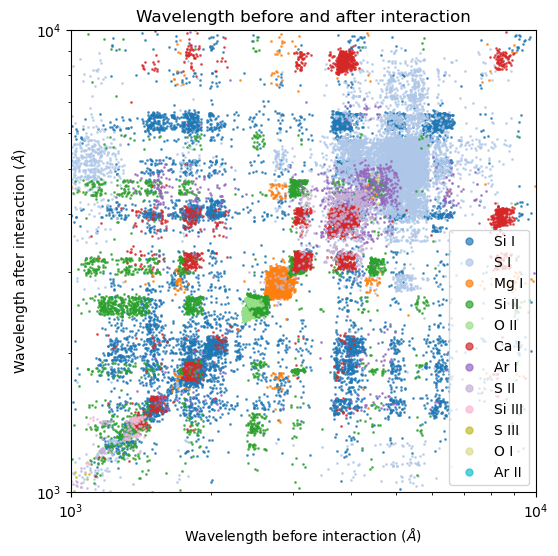

In [45]:
from tardis.util.base import atomic_number2element_symbol, int_to_roman

# first extract the line list from the simulation (recall from the Notebooks from Day 2 and 3)
line_list = sim.plasma.atomic_data.lines.reset_index()

# find the interaction line id to identify the ion
line_in_ids = sim.transport.transport_state.last_line_interaction_in_id[
    line_interaction_mask
]
line_out_ids = sim.transport.transport_state.last_line_interaction_out_id[
    line_interaction_mask
]
line_in = line_list.loc[line_in_ids]
line_out = line_list.loc[line_out_ids]

# generate label for each line using the element + ionization state
line_in["ion_name"] = [
    f"{atomic_number2element_symbol(int(line['atomic_number']))} {int_to_roman(int(line['ion_number']))}"
    for _, line in line_in.iterrows()
]
line_out["ion_name"] = [
    f"{atomic_number2element_symbol(int(line['atomic_number']))} {int_to_roman(int(line['ion_number']))}"
    for _, line in line_out.iterrows()
]

# now let's color code the points by the ion type
plt.figure(figsize=(6, 6))
colors = plt.cm.tab20(np.linspace(0, 1, len(line_in["ion_name"].unique())))
for ion_name, color in zip(line_in["ion_name"].unique(), colors):
    if ion_name.endswith(' '):
        pass
    else:
        mask = line_in["ion_name"] == ion_name
        plt.plot(
            wavelength_before_interaction[mask],
            wavelength_after_interaction[mask],
            "o",
            markersize=1,
            alpha=0.7,
            label=ion_name,
            zorder=1,
            color=color,
        )
plt.xlabel(r"Wavelength before interaction ($\AA$)")
plt.ylabel(r"Wavelength after interaction ($\AA$)")
plt.title("Wavelength before and after interaction")
plt.xscale("log")
plt.yscale("log")
plt.xlim(1e3, 1e4)
plt.ylim(1e3, 1e4)
plt.legend(markerscale=5)
plt.show()


### Connecting Atomic Physics to Observed Spectra

**$\blacktriangleright$ The Complete Picture** - Now you can see how atomic physics creates the spectral features we observe.

The element-specific patterns in the wavelength redistribution plot directly connect to spectral line formation:

1. **Symmetry and asymmetry:** All lines that can absorb can also emit, but the dependence of the absorption on the radiation field strength breaks symmetry about the 1-to-1 line.
2. **Line strength correlation:** Heavy vertical patches in the interaction plot correspond to strong absorption features in the spectrum
3. **Frequency redistribution:** The macro atom's ability to redistribute photon energies is what creates the complex line profiles we see

This visualization shows you exactly where the strongest line interactions occur and how they redistribute energy across the spectrum.

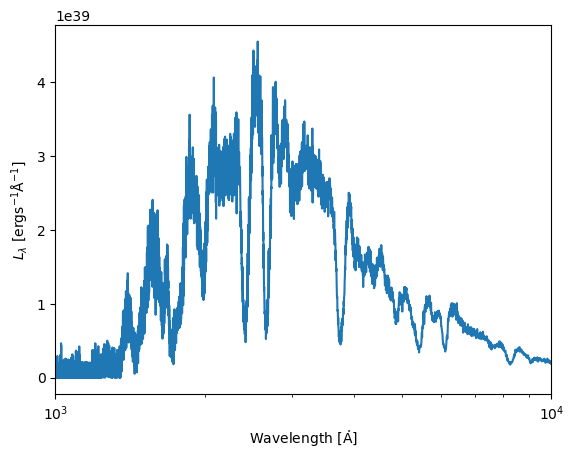

In [16]:
sim.spectrum_solver.spectrum_virtual_packets.plot()
plt.xlim(1e3, 1e4)
plt.xscale("log")

And now let's plot both of these on the on top of each other so we can see how the patches line up with the heavy line features in the spectrum.

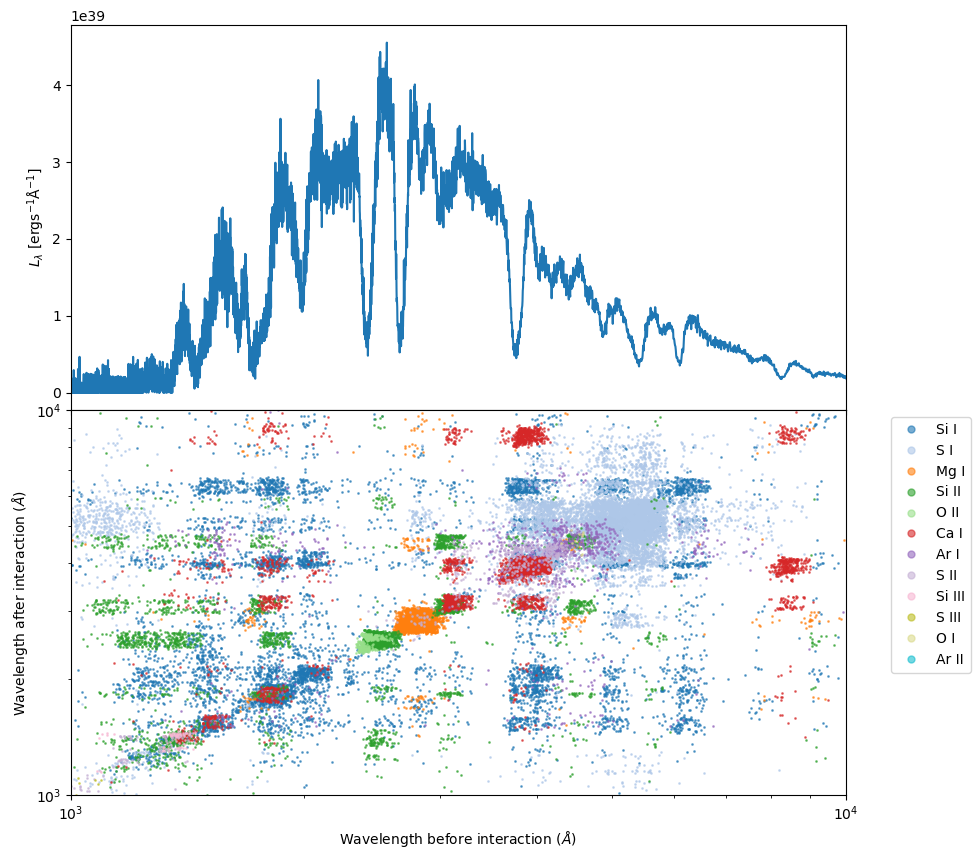

In [47]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

# Plot the spectrum on the top subplot
sim.spectrum_solver.spectrum_virtual_packets.plot(ax=ax1)
ax1.set_xlabel('')  # Remove x-label from top plot

# Plot the interaction data on the bottom subplot
colors = plt.cm.tab20(np.linspace(0, 1, len(line_in["ion_name"].unique())))
for ion_name, color in zip(line_in["ion_name"].unique(), colors):
    if ion_name.endswith(' '):
        pass
    else:
        mask = line_in["ion_name"] == ion_name
        ax2.plot(
            wavelength_before_interaction[mask],
            wavelength_after_interaction[mask],
            "o",
            markersize=1,
            alpha=0.6,
            label=ion_name,
            zorder=1,
            color=color,
        )

ax2.set_xlabel(r"Wavelength before interaction ($\AA$)")
ax2.set_ylabel(r"Wavelength after interaction ($\AA$)")
ax2.set_xscale("log")
ax2.set_yscale("log")
ax2.set_xlim(1e3, 1e4)
ax2.set_ylim(1e3, 1e4)
ax2.legend(markerscale=5, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.subplots_adjust(hspace=0)
plt.show()


**$\blacktriangleright$ TASK: Analyze Element-Specific Line Redistribution**

Study the combined plot above that shows both the spectrum and the wavelength redistribution patterns by element. This visualization reveals how specific atomic species create the spectral features we observe.

**Your Analysis Tasks:**

1. **Identify Dominant Elements:**
   - How do these strong redistribution regions correspond to absorption features in the spectrum above?
   - Which elements show the strongest vertical "columns" in the redistribution plot? Can you always identify a single element for the strong line features in the spectrum?

2. **Physical Interpretation:**
   - Why do some elements (like Ca II, Si II) show such prominent redistribution patterns?
   - What does the concentration of points near the diagonal tell you about the relative importance of scattering vs. fluorescence?

**Key Insight:** This plot directly shows you how the macro atom's complex atomic physics creates the spectral features that astronomers use to identify elements in supernova ejecta.

## solution**
1. Dominant Elements:**
-  Strong features in the spectra correspond to many redistribution distributing packets out of certain frequencies to other ones. 
-  b Often lines in SN spectra come from multiple different elements. 

**2. Physical Interpretation:**
- **Prominent redistribution patterns:** Si II and Ca II show strong patterns because they have favorable ionization states in the supernova ejecta conditions and possess strong transitions that efficiently absorb the radiation field. These elements also have multiple accessible energy levels that enable complex fluorescence cascades.
- **Diagonal concentration vs. redistribution:** The heavy concentration near the diagonal indicates that elastic scattering remains the dominant process even with macro atom physics. However, the significant off-diagonal structure shows that fluorescence and cascade processes are important for redistributing energy, particularly for strong lines. The vertical "streaks" away from the diagonal represent packets being absorbed at one wavelength but re-emitted across a range of wavelengths through different atomic transitions.

# LTE vs NLTE: When Physics Assumptions Matter

Local Thermodynamic Equilibrium (LTE) is a powerful simplification, but supernova ejecta often violate its assumptions. Understanding when and how to depart from LTE is crucial for accurate modeling.

**$\blacktriangleright$ LTE Assumptions and Their Breakdown:**

LTE assumes that collision rates dominate over radiative rates, leading to equilibrium distributions. In supernova ejecta:
1. **Low densities:** Collision rates may be too low for equilibrium
2. **Strong radiation fields:** Photoionization and photoexcitation become important
3. **Large scale lengths:** Radiation can escape before establishing equilibrium

TARDIS provides several "NLTE" treatments that modify LTE assumptions in physically motivated ways for explosive transients.

In [48]:
conf.plasma.excitation

'dilute-lte'

In [49]:
conf.plasma.ionization

'nebular'

### Recommended NLTE Settings for Explosive Transients

**$\blacktriangleright$ Best Practice Configuration:**

For explosive transients, we recommend:
- **Excitation:** `dilute-lte` - accounts for diluted radiation field effects on level populations
- **Ionization:** `nebular` - includes photoionization and recombination in low-density environments

These settings modify LTE treatment in ways that have been shown to be more accurate for supernova-like conditions where densities are low and radiation fields are strong.

**Why these matter:** Let's compare full LTE treatment with these recommended NLTE modifications to see how dramatically they can affect both the plasma state and the resulting spectrum.

In [50]:
conf.plasma.excitation = 'lte'
conf.plasma.ionization = 'lte'
sim_lte_plasma = run_tardis(conf)

BokehModel(combine_events=True, render_bundle={'docs_json': {'1c6eb714-d64d-4328-949c-e9b02ef321a6': {'version…

TqdmHBox(children=(HTML(value='Packets:\u2007\u2007\u2007', layout=Layout(width='6%')), FloatProgress(value=0.…

TqdmHBox(children=(HTML(value='Iterations:', layout=Layout(width='6%')), FloatProgress(value=0.0, layout=Layou…

Let's begin by comparing the ion number densities of a couple elements to see how much they care about LTE vs. NLTE solvers. You can play around with the SHELL_ID and ATOMIC NUMBER like in previous notebooks to examine the elements of your choice, in the shells of your choice. 

Below, we set up the first plot to examine Argon in the 10th shell, halfway out. 

(0.0, 4.0)

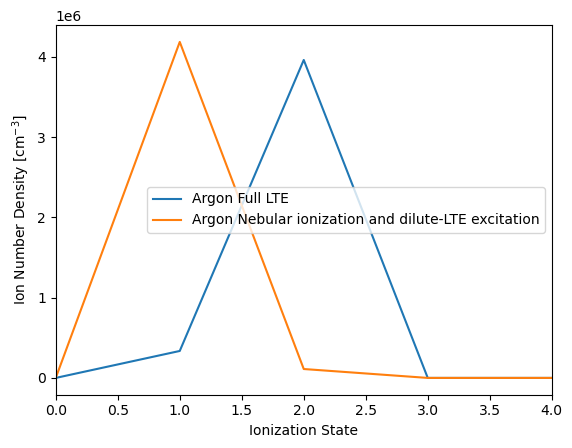

In [51]:
SHELL_ID = 10
ATOMIC_NUMBER = 18
plt.plot(sim_lte_plasma.plasma.ion_number_density.loc[ATOMIC_NUMBER][SHELL_ID], label = 'Argon Full LTE')
plt.plot(sim.plasma.ion_number_density.loc[ATOMIC_NUMBER][SHELL_ID], label='Argon Nebular ionization and dilute-LTE excitation')

plt.legend()
plt.xlabel('Ionization State')
plt.ylabel('Ion Number Density [cm$^{-3}$]')
plt.xlim(0, 4)

### Dramatic Impact on Ionization Balance

**$\blacktriangleright$ Case Study: Argon** - For elements with sensitive ionization edges, the choice of physics treatment can completely change which ionization state dominates.

**Physical insight:** The difference between LTE and nebular ionization is most pronounced for elements where photoionization competes strongly with collisional ionization. Argon's ionization energy makes it particularly sensitive to these effects.

Now let's examine Oxygen, which we saw in a previous notebook was particularly insensitive to small changes in temperature. 

(0.0, 4.0)

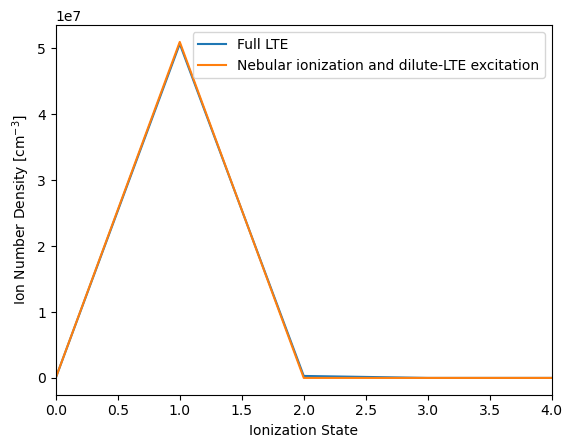

In [ ]:
SHELL_ID = 10
ATOMIC_NUMBER = 8
plt.plot(sim_lte_plasma.plasma.ion_number_density.loc[ATOMIC_NUMBER][SHELL_ID], label = 'Full LTE')
plt.plot(sim.plasma.ion_number_density.loc[ATOMIC_NUMBER][SHELL_ID], label='Nebular ionization and dilute-LTE excitation')

plt.legend()
plt.xlabel('Ionization State')
plt.ylabel('Ion Number Density [cm$^{-3}$]')
plt.xlim(0, 4)

### Element-Dependent Sensitivity

**$\blacktriangleright$ Contrast: Oxygen** - Different elements show varying sensitivity to the physics treatment.

**Why the difference:** Oxygen's ionization energy and the specific conditions in this model make it less sensitive to the LTE vs NLTE treatment compared to Argon. This demonstrates why understanding the physics is crucial - the importance of different approximations depends on the specific element and physical conditions.

(0.0, 4.0)

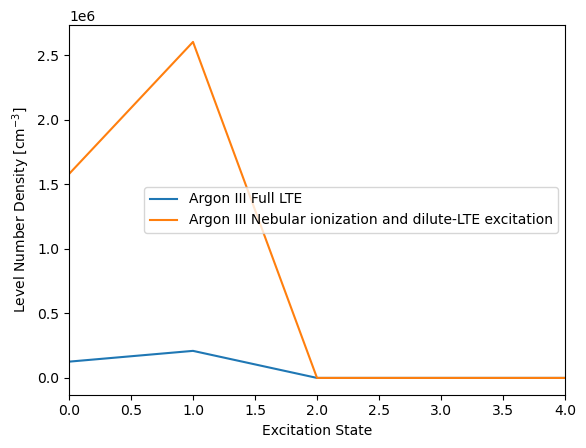

In [54]:
SHELL_ID = 10
ATOMIC_NUMBER = 18
plt.plot(sim_lte_plasma.plasma.level_number_density.loc[ATOMIC_NUMBER, 1][SHELL_ID], label = 'Argon III Full LTE')
plt.plot(sim.plasma.level_number_density.loc[ATOMIC_NUMBER, 1][SHELL_ID], label='Argon III Nebular ionization and dilute-LTE excitation')

plt.legend()
plt.xlabel('Excitation State')
plt.ylabel('Level Number Density [cm$^{-3}$]')
plt.xlim(0, 4)

### Excitation Effects Propagate Through the Physics

**$\blacktriangleright$ Cascading Changes** - The ionization balance changes create corresponding shifts in the excitation level populations.

This demonstrates how physics approximations cascade through the entire calculation: ionization changes affect which ions are present, which affects level populations, which affects line opacities, which affects the final spectrum.

(1000.0, 10000.0)

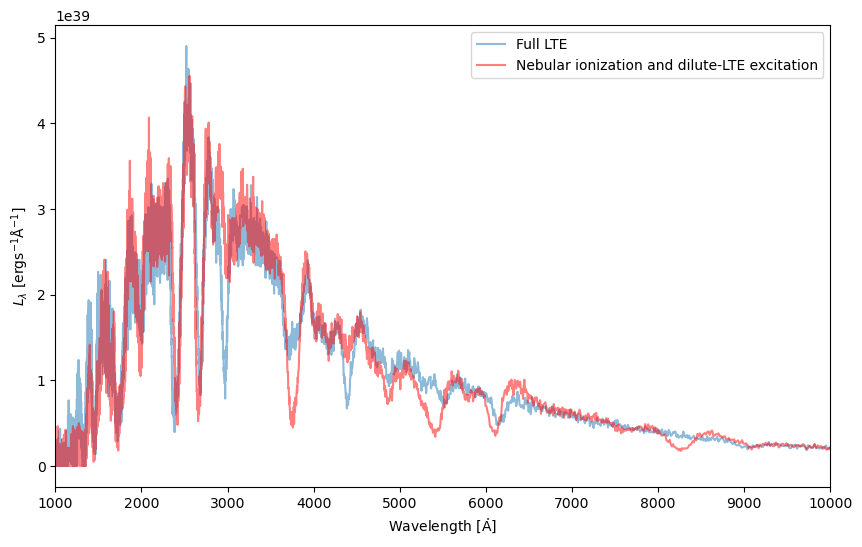

In [56]:
plt.figure(figsize=(10, 6))
sim_lte_plasma.spectrum_solver.spectrum_virtual_packets.plot(label='Full LTE', alpha=0.5)
sim.spectrum_solver.spectrum_virtual_packets.plot(label='Nebular ionization and dilute-LTE excitation', alpha=0.5, color='red')
plt.legend()
plt.xlim(1e3, 1e4)

### Critical Lesson: Physics Choices Have Major Consequences

**$\blacktriangleright$ Spectroscopic Impact** - The dramatically different spectra demonstrate why understanding the underlying physics is crucial for research.

**Key takeaway:** Choosing appropriate physics treatments isn't just an academic exercise - it can mean the difference between correct and incorrect scientific conclusions. The "best" treatment depends on your specific physical conditions and scientific goals.

**For explosive transients:** The recommended NLTE settings (dilute-LTE excitation, nebular ionization) are generally more appropriate than full LTE for the low-density, radiation-dominated environments typical of supernova ejecta.

# Estimators: Connecting Packets to Plasma

Estimators are the bridge between Monte Carlo packets and the plasma state. They track how packets interact with the plasma and provide the radiation field information needed to calculate ionization and excitation balance.

**$\blacktriangleright$ One Example Understanding J-Nu Estimators:**

The J-Nu estimator tracks the mean intensity of radiation approaching each atomic line from the nu (high-frequency) side. This quantity is crucial for calculating macroatom transition probabilities that care about stimulated emission. 

The plots below show these estimators across different shells and wavelengths, revealing the detailed radiation field structure that determines the plasma state.

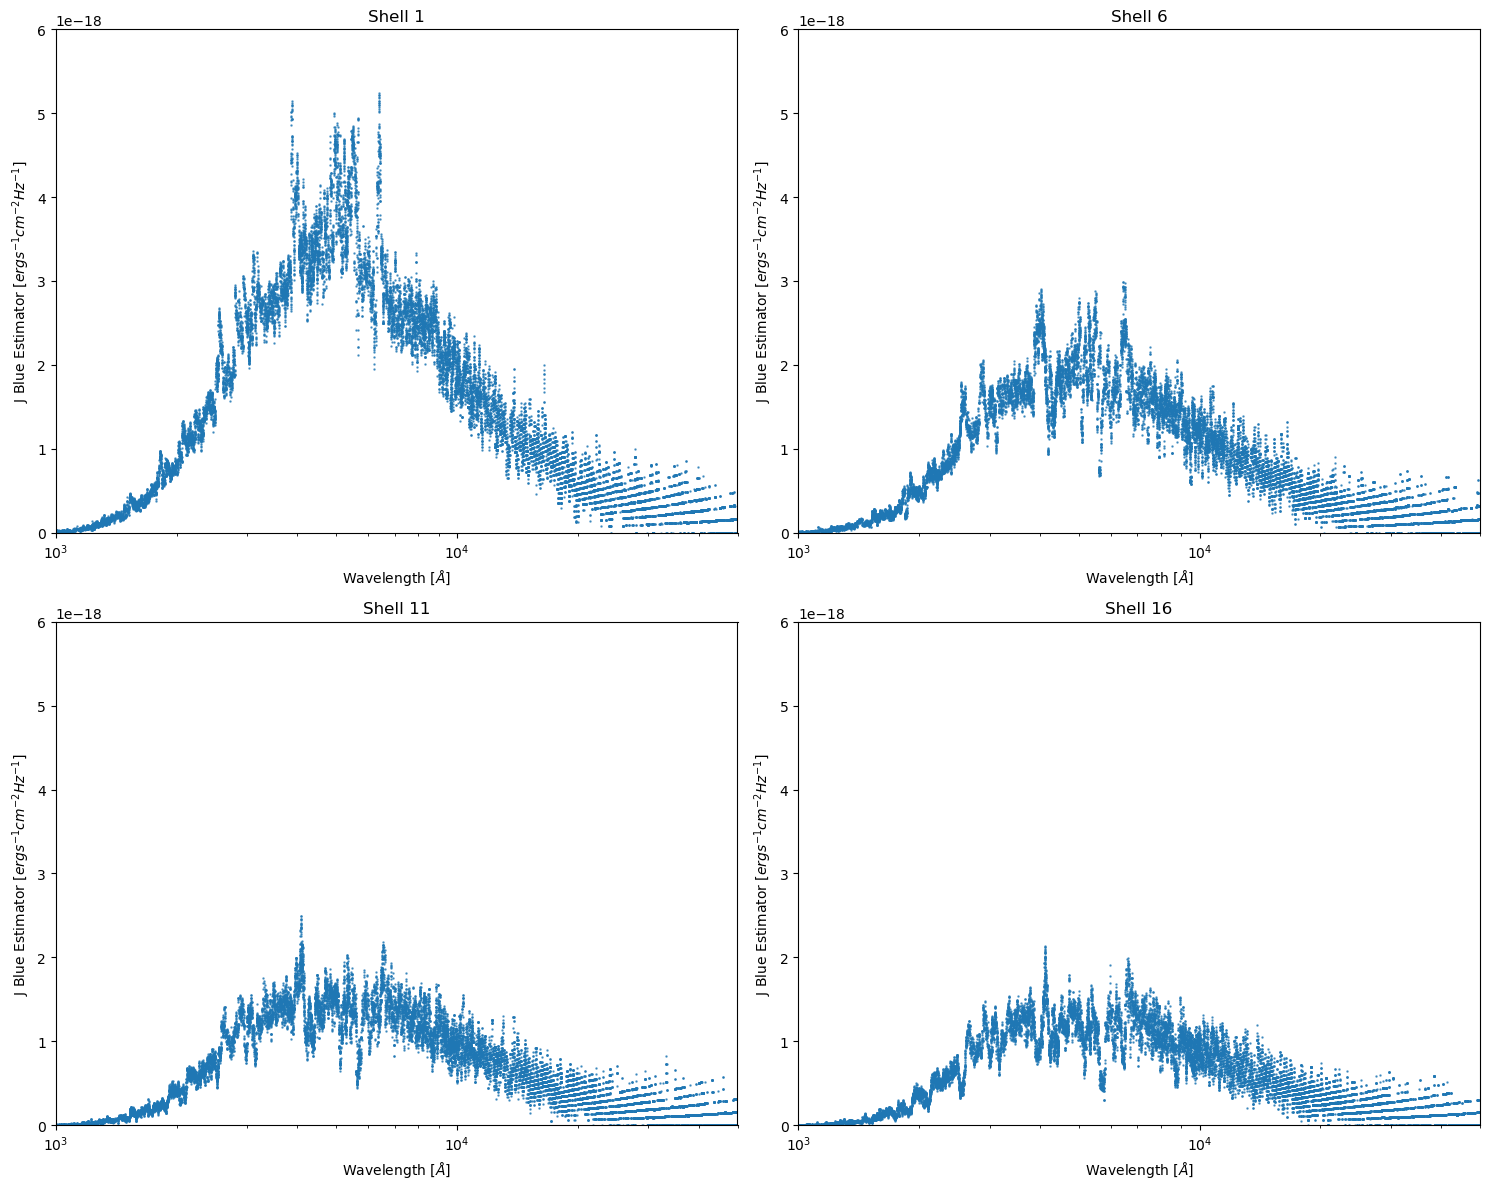

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

for subplot_idx in range(4):
    for index, estimator in enumerate(sim.transport.transport_state.j_nu_estimator.T[::5]):
        if index % 4 == subplot_idx:  # Distribute shells across subplots
            axes[subplot_idx].scatter(sim.plasma.atomic_data.lines.wavelength, estimator, alpha=0.7, s=0.6)
    
    axes[subplot_idx].set_xscale('log')
    axes[subplot_idx].set_xlim(1e3, 5e4)
    axes[subplot_idx].set_ylim(0, 6e-18)
    axes[subplot_idx].set_xlabel(r'Wavelength [$\AA$]')
    axes[subplot_idx].set_ylabel(r'J Blue Estimator [$erg s^{-1} cm^{-2} Hz^{-1}$]')
    axes[subplot_idx].set_title(f'Shell {subplot_idx * 5 + 1}')

plt.tight_layout()
plt.show()

**$\blacktriangleright$ TASK**: Understanding the J-nu Estimator Structure

**$\blacktriangleright$ Critical Analysis Questions** - Study the J-nu estimator plots above and think about the physical meaning:

1. **Overall Shape:** Why does the J-nu estimator show higher values at shorter wavelengths (UV region) and generally decrease toward longer wavelengths? What does this tell you about the radiation field spectrum?

2. **Shell-to-Shell Variation:** Compare the different shells (subplots). How and why do the estimator values change as you move from inner to outer shells? What physical processes cause these differences?

3. **Zero Values:** Why are there many atomic lines with essentially zero J-nu estimator values? What does this reveal about which lines are actually being interacted with by the radiation field?

**Physical Connection:** Remember that these estimators directly determine the excitation and ionization balance of the plasma. The structure you see in these plots is what creates the specific plasma conditions that generate the final spectrum you observe.

## solution

**1. Overall Shape:**
The J-nu estimator follows a blackbody-like spectrum peaking in the UV region because the inner boundary emits as a hot blackbody ($\sim$10,000 K). The decrease toward longer wavelengths reflects Wien's displacement law - most photons are emitted at shorter wavelengths for this temperature. This reveals that the radiation field is dominated by the hot inner boundary emission.

**2. Shell-to-Shell Variation:**
The estimator values systematically decrease from inner to outer shells because the radiation field dilutes geometrically as $r^{-2}$. Additionally, line absorption progressively removes photons from the radiation field as packets propagate outward, further reducing the intensity. This geometric and absorptive dilution creates the shell-to-shell intensity gradient.

**3. Zero Values:**
Many atomic lines have zero J-nu estimator values because they are either: (a) not accessible given the radiation field spectrum and plasma conditions, (b) have negligible line opacity due to low ion populations, or (c) are at wavelengths where few Monte Carlo packets propagate. Only lines that are both optically significant and in spectral regions with substantial photon flux receive non-zero estimator contributions.

Congratulations on learning so much about how TARDIS works! Tomorrow we will explore how to use TARDIS in full research scenarios, and how you can set up physically interesting models!

In [59]:
from IPython import get_ipython
from pathlib import Path
ip = get_ipython()
path = None
if '__vsc_ipynb_file__' in ip.user_ns:
    path = ip.user_ns['__vsc_ipynb_file__']

nb_path = Path(path)
# Get the current notebook name
current_notebook = nb_path.name

# Create the student version by replacing 'instructor' with 'student'
output_notebook = current_notebook.replace('instructor', 'student')

# Run the nbconvert command
!jupyter nbconvert {current_notebook} --TagRemovePreprocessor.enabled=True --TagRemovePreprocessor.remove_cell_tags="['solution']" --to notebook --output {output_notebook}

print(f"Converted {current_notebook} to {output_notebook}")


[NbConvertApp] Converting notebook 4_tardis_macroatom_estimators_instructor.ipynb to notebook
[NbConvertApp] Writing 1661139 bytes to 4_tardis_macroatom_estimators_student.ipynb
Converted 4_tardis_macroatom_estimators_instructor.ipynb to 4_tardis_macroatom_estimators_student.ipynb
